In [1]:
from IPython.display import SVG

# Cuckoo Filter 

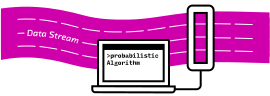

In [2]:
SVG(filename='./images/03.svg')

### Introduction and Post Summary

Probabilistic data structures store data compactly with low memory and provide approximate answers to queries about stored data. They are designed to answer queries in a space-efficient manner, which can mean sacrificing accuracy. However, they typically provide guarantees and bounds on error rates depending on specifications of the data structure in question. Because they provide low memory footprints, probabilisitic data structures are particularly useful in streaming and low power settings. As such, they are extremely useful in big data situations like counting views on a video or maintaining a list of unique tweets in the past. A single HyperLogLog++ structure, for example, can count up to 7.9 billion unique items using 2.56KB of memory with only a 1.65% error rate. 

The Fast Forward Labs team explored probabilistic data structures in our "Probabilistic Methods for Real-time Streams" report and prototype (contact us if you're interested in this topic). This post provides an update by exploring Cuckoo filters, a [new](https://www.cs.cmu.edu/~dga/papers/cuckoo-conext2014.pdf) probabilistic data structure that improves upon the standard Bloom filter by reducing false positive rates and enabling support to delete items seen in the past. We provide a python implementation of the Cuckoo filter, comparing it to a counting Bloom filter (a Bloom filter variant). 

### Application

While they seem esoteric, probabilistic data structures are very useful. Consider large scale internet applications like Twitter that struggle to keep new users engaged. To tackle this, Twitter's growth & engagement team develop marketing campaigns to encourage new and unengaged users to use Twitter more often. To aid this work, every new user can be added to a Cuckoo filter. When he/she becomes active, he/she can be removed, and the engagement team can target growth campaigns to individuals currently in the Cuckoo filter. The Cuckoo filter can add and remove users down the line depending on their activity level. Cuckoo filters are easy to implement, so are a good choice for this use case. With hundreds of millions of users, it helps to have a low memory footprint and low false positive rates. 

### Bloom filter overview

 [Bloom filters](https://en.wikipedia.org/wiki/Bloom_filter) are a popular probabilistic data structure that allow space-efficient testing of set membership. When monitoring a real-time stream of tweets, for example, a Bloom filter allows us to test whether a tweet is new or has been seen before. Bloom filters use hash functions to compactly encode items as integers; these serve as indices of a bit array that is then set. To test if an item has been seen before, a Bloom filter hashes the item to produce its set of indices, and each index is checked to see if it has been set. Since it's possible to hash multiple items to the same indices, a membership test returns either false or maybe. That means, Bloom filters give no false negatives but a controllable rate of false positives. If a Bloom filter indicates that an item has not been seen before, we can be certain that's the case; but if it indicates an item has been seen, it's possible that's not the case (a false positive).

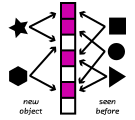

In [3]:
SVG(filename='./images/14.svg')

Traditional Bloom filters do not support deletions because hashing is lossy and irreversible. That means, deletions require the entire filter to be rebuilt. But what if we want to delete items seen in the past, like certain tweets in the Twitter example above? The counting Bloom filter was introduced to solve this problem. To support deletions, counting Bloom filters extend buckets in traditional Bloom filters from single bit values to n-bit counters. Here, insertions increment rather than set Bloom filter indices. 

### Cuckoo filter

The Cuckoo filter is an alternative to the Bloom filter when one requires support for 
deletions. They were introduced in [2014](https://www.cs.cmu.edu/~dga/papers/cuckoo-conext2014.pdf) by Fan et. al. Like the counting Bloom filter, Cuckoo filters provide insert, delete, and lookup capabilities. However, Cuckoo filters use different underlying data structures and different insertion procedures than Bloom filters.

The Cuckoo filter consists of a [Cuckoo hash table](http://web.stanford.edu/class/archive/cs/cs166/cs166.1146/lectures/13/Small13.pdf) that stores the 'fingerprints' of items inserted. The fingerprint of an item is a bit string derived from the hash of that item. A cuckoo hash table consists of an array of buckets where an item to be inserted is mapped to two possible buckets based on two hash functions. Each bucket can be configured to store a variable number of fingerprints. Typically, a Cuckoo filter is identified  by its fingerprint and bucket size. For example, a (2,4)
Cuckoo filter stores 2 bit length fingerprints and each bucket in the Cuckoo hash table can store up to 4 fingerprints. Following the above [paper](https://www.cs.cmu.edu/~dga/papers/cuckoo-conext2014.pdf), we implemented the cuckoo filter in python [link to final repo]. Below, we initialize an example cuckoo filter and test simple inserts and deletions. We also implement a counting Bloom filter to compare performance. 

In [4]:
from cuckoofilter import CuckooFilter
c_filter = CuckooFilter(10000, 2) #specify capacity and fingerprint size

In [5]:
c_filter.insert("James")
print("James in c_filter == {}".format("James" in c_filter))

c_filter.remove("James")
print("James in c_filter == {}".format("James" in c_filter))

James in c_filter == True
James in c_filter == False


In [6]:
from cuckoofilter import CountingBloomFilter
b_filter = CountingBloomFilter(10000) #specify the capacity of a counting bloom filter

b_filter.add("James")
print("James in b_filter == {}".format("James" in b_filter))

b_filter.remove("James")
print("James in b_filter == {}".format("James" in b_filter))

James in b_filter == True
James in b_filter == False


### Inserting into a Cuckoo filter

<img src="./images/cuckoo_hashing_illustration_from_bin_et_al_paper.png">

The Cuckoo filter supports three key operations: insert, delete, and lookup. The figure above, from the Fan et. al. paper, shows how insertion into the Cuckoo filter works. Of all the Cuckoo filter operations, the insert operation is most involved. To insert an item into the Cuckoo filter, one derives two indices from the item based on hashing the item and its fingerprint. On obtaining these indices, one then inserts the item's fingerprint into one of the two possible buckets that correspond to the derived indices. In our implementation, we default to the first index. As the Cuckoo hash table begins to fill up, one can encounter a situation where the two possible indices where an item can be inserted has been filled. In this case, items currently in the Cuckoo hash table are swapped to their alternative indices to free up space for inserting the new item. By implementing insertion in this manner, one can easily delete an item from the table by looking up its fingerprint in one of two possible indices, and deleting this fingerprint if present. To make the insertion procedure more concrete, we provide code below implementing the insertion procedure.

In [7]:
#example function to demonstrate how to insert into a cuckoo filter. 

import mmh3

def obtain_indices_from_item(item_to_insert, fingerprint_size, capacity):
    
    #hash the string item 
    hash_value = mmh3.hash_bytes(item_to_insert)
    
    #subset the hash to a fingerprint size
    fingerprint = hash_value[:fingerprint_size]
    
    #derive the index
    index_1 = int.from_bytes(hash_value, byteorder="big")
    index_1 = index_1 % capacity
    
    #derive the index from the fingerprint
    hashed_fingerprint = mmh3.hash_bytes(fingerprint)
    finger_print_index = int.from_bytes(hashed_fingerprint, byteorder="big")
    finger_print_index = finger_print_index % capacity
    
    #second index -> first_index xor index derived from hash(fingerprint)
    index_2 = index_1 ^ finger_print_index
    index_2 = index_2 % capacity
    
    return index_1, index_2, fingerprint

def insert_into_table(table, index_1, index_2, bucket_capacity):
    #now insert item into the table
    if len(table[index_1]) < bucket_capacity:
        table[index_1].append(fp)
        return table, index_1

    if len(table[index_1]) < bucket_capacity:
        table[index_2].append(fp)
        return table, index_2

    #Move items to other positions in the table. 
    
    return "Unable to Insert Item"    

In [8]:
#let's create a crude cuckoo hashtable
capacity = 10 #capacity of our cuckoo hashtable
bucket_capacity = 4
table = [[] for _ in range(capacity)]

In [9]:
#obtain possibe indices
index_1, index_2, fp = obtain_indices_from_item("James", 2, 10)

#now let's insert "James into the table"
table, _ = insert_into_table(table, index_1, index_2, bucket_capacity)

print("Table after James is inserted.")
#check to see that "james" has been inserted
print(table)

Table after James is inserted.
[[], [], [], [], [], [], [], [], [], [b'\xc0\n']]


In [10]:
#let's insert "james" again. 
index_1, index_2, fp = obtain_indices_from_item("James", 2, 10)

#now let's insert "James into the table"
table, _ = insert_into_table(table, index_1, index_2, bucket_capacity)

print("Table after James is inserted a second time.")
#now let's check to see that "James" has been inserted again
print(table)
print("\n")

#let's insert a different item now
index_1, index_2, fp = obtain_indices_from_item("Henry", 2, 10)

table, _ = insert_into_table(table, index_1, index_2, bucket_capacity)

print("Table after Henry is inserted.")
#now let's check to see that "Henry" has been inserted into the table. 
print(table)

Table after James is inserted a second time.
[[], [], [], [], [], [], [], [], [], [b'\xc0\n', b'\xc0\n']]


Table after Henry is inserted.
[[], [], [b'\x1c\xb2'], [], [], [], [], [], [], [b'\xc0\n', b'\xc0\n']]


## Bench marking against counting Bloom filter

### False positive rate comparison
Let's compare the Cuckoo filter to the counting Bloom filter. A critical metric for probabilistic data structures like the Bloom and Cuckoo filters is the false positive rate. As shown in the insertion section, comparing the Cuckoo filter and the Bloom filter can be tricky given the difference in their internal workings. To tackle the issue of false positive rates, we  fix the space allocation for both filters and then vary the capacities in order to observe the change in false positive rate. Below we show a graph of the false positive rate vs the capacity for both structures. 

<img src="./images/false_positive_(0.1MB).png">

As seen in the graph, a key advantage of the Cuckoo filter is that with fixed space, the Cuckoo filter provides much lower false positive rates at smaller capacities. As noted in the original paper, for applications that desire lower than 3 percent false positive rate (blue dashed line), the Cuckoo filter is particularly ideal.  Of note is that the Cuckoo filter here is a straightforward implementation without any space optimizations. This further indicates that a Cuckoo filter provides better performance without any tuning compared to optimized Bloom filters. See [Notebook](https://github.com/fastforwardlabs/cuckoofilter/blob/master/bench_marking_notebook.ipynb) for other performance benchmarks comparing the counting Bloom filter to the Cuckoo filter. 

### Insertion throughput comparison

Another important metric to consider is the insertion throughput. Insertion throughput is essentially how long it takes to insert an item in an existing filter. From the design of the Counting Bloom filter, time to insert into the filter does not change as the filter fills up. However, with the Cuckoo filter, time to insert into the filter increases as the filter fills up to capacity. If an item is to be inserted into a Cuckoo table, and both of its possible indices are fully occupied, then the current items are swapped to their alternative indices to free up space for the item being inserted. As the Cuckoo table fills up, more swapping would typically occur as there are more items to relocate. 

The figure below shows the insertion time for a counting Bloom filter and a Cuckoo filter of the same capacites as both fill up (See [Notebook](https://github.com/fastforwardlabs/cuckoofilter/blob/master/bench_marking_notebook.ipynb) for details). With the Cuckoo filter, we notice an insertion throughput increase of up to 85 percent as it fills up to 80 percent capacity, while the insertion throughput for the counting Bloom filter remains relatively stable over this range. In the figure, we further notice that the Cuckoo filter is about 3 times faster than the counting Bloom filter 
over the entire range despite the significant increase in insertion throughput for the Cuckoo filter. While such differences are significant here, counting Bloom filters can be optimized to provide similar insertion speeds to Cuckoo filters. Here we seek to emphasize the significant change in insertion throughput that occurs as a Cuckoo filter fills up. 

<img src="./images/load_factor.png">

## Conclusion

Bloom filters and its variants have proven useful in streaming applications and others where membership testing is critical. In this post, we have shown how a Cuckoo filter, which can be implemented simply, provides better practical performance, under certain circumstances, out of the box and without tuning than counting Bloom filters. Ultimately, Cuckoo filters can serve as alternatives in scenarios where a counting Bloom filter would normally be used. 